# TF isoform data


## TODO

- move data loading functions into file
- get sequence information
- check valid clones only in all data
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [16]:
from itertools import combinations

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt


%matplotlib inline

In [2]:
def load_isoform_and_paralog_ppi_data():
    """
    - NS: sequencing failed
    - NC: no call
    
    """
    valid_clones = set(pd.read_sql("""SELECT unique_acc
                                        FROM tf_screen.iso6k_annotation;""",
                                   ccsblib.paros_connection())['unique_acc'].values)
    qry_a = """select a.category,
                      a.ad_orf_id,
                      b.unique_acc AS ad_clone_acc,
                      a.ad_symbol AS ad_gene_symbol,
                      a.db_orf_id,
                      c.symbol AS db_gene_symbol,
                      a.final_score AS score
                 FROM tf_screen.tf_isoform_final AS a 
                 LEFT JOIN tf_screen.iso6k_sequences AS b 
                   ON a.ad_orf_id = b.orf_id 
                 LEFT JOIN horfeome_annotation_gencode27.orf_class_map_ensg AS c 
                   ON a.db_orf_id = c.orf_id;"""
    df_a = pd.read_sql(qry_a, ccsblib.paros_connection())
    df_a = df_a.loc[df_a['ad_clone_acc'].isin(valid_clones), :]
    
    # remove duplicate ORF for gene DDX39B, where sequencing mostly failed
    df_a = df_a.loc[df_a['db_orf_id'] != 3677, :]
    
    df_a['category'] = df_a['category'].map({'ppi': 'tf_isoform_ppis',
                                             'ng_stem_cell_factor': 'tf_isoform_ppis',
                                             'rrs': 'rrs_isoforms',
                                             'litbm': 'lit_bm_isoforms'})
    qry_b = """select a.simple_category AS category,
                      a.ad_orf_id,
                      b.unique_acc AS ad_clone_acc,
                      a.ad_symbol AS ad_gene_symbol,
                      a.db_orf_id,
                      c.symbol AS db_gene_symbol,
                      a.final_score AS score
                 FROM tf_screen.paralog_final AS a 
                 LEFT JOIN tf_screen.iso6k_sequences AS b 
                   ON a.ad_orf_id = b.orf_id 
                 LEFT JOIN horfeome_annotation_gencode27.orf_class_map_ensg AS c 
                   ON a.db_orf_id = c.orf_id;"""
    df_b = pd.read_sql(qry_b, ccsblib.paros_connection())
    df_b = df_b.loc[df_b['ad_clone_acc'].isin(valid_clones), :]
    df_b['category'] = df_b['category'].map({'paralog': 'tf_paralog_ppis',
                                             'PDI_PPI': 'paralog_with_PDI',
                                             'nonparalog': 'non_paralog_control',
                                             'rrs': 'rrs_paralogs',
                                             'litbm': 'lit_bm_paralogs'})
    df = pd.concat([df_a, df_b])
    # drop cases where single orf ID mapped to multiple gene symbols
    df = df.drop_duplicates(['category', 'ad_orf_id', 'db_orf_id'])
    # drop interaction partner ORFs whose sequence does not map to an ensembl gene
    df = df.dropna(subset=['db_gene_symbol'])
    return df


y2h = load_isoform_and_paralog_ppi_data()

In [3]:
def load_tf_isoform_screen_results():
    """There were two screens performed:
    
    The cloned TF isoforms as AD-fusions against DB-fusions of:
    (1) ORFeome 9.1
    (2) Subset of TFs and co-factors
    
    Returns:
        pandas.DataFrame: for each pair, was it found in the first and second screens
        
    """
    qry = """SELECT ad_orf_id,
                    db_orf_id,
                    pool_name 
               FROM swimseq_run.INGS_IST a,
                    swimseq_run.NGS_POOL b 
              WHERE a.pool_id = b.pool_id 
                AND a.pool_id in (787, 788)  
                AND ist_score>=0.2;"""
    df = pd.read_sql(qry, ccsblib.paros_connection())
    df = (pd.get_dummies(df, columns=['pool_name']).groupby(['ad_orf_id', 'db_orf_id']).sum() > 0).reset_index()
    df = df.rename(columns={'pool_name_ds20180213_TFisoS04': 'in_orfeome_screen',
                            'pool_name_ds20180213_TFisoS05': 'in_focussed_screen'})
    if not (df['in_orfeome_screen'] | df['in_focussed_screen']).all():
        raise UserWarning('Something went wrong...')
    return df


"""
# Need to map the screen data to the gene level... 
screen = load_tf_isoform_screen_results()
pd.merge(y2h,
         screen,
         how='left',
         on=['ad_orf_id', 'db_orf_id']).sort_values(['ad_gene_symbol', 'db_gene_symbol'])
"""

"\n# Need to map the screen data to the gene level... \nscreen = load_tf_isoform_screen_results()\npd.merge(y2h,\n         screen,\n         how='left',\n         on=['ad_orf_id', 'db_orf_id']).sort_values(['ad_gene_symbol', 'db_gene_symbol'])\n"

In [4]:
iso_pairs = []
for tf_gene in y2h.loc[y2h['category'] == 'tf_isoform_ppis', 'ad_gene_symbol'].unique():
    isoforms = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                      (y2h['ad_gene_symbol'] == tf_gene),
                      'ad_clone_acc'].unique()
    for iso_a, iso_b in combinations(isoforms, 2):
        iso_pairs.append((tf_gene, iso_a, iso_b))
iso_pairs = pd.DataFrame(data=iso_pairs,
                         columns=['tf_gene_symbol', 'clone_acc_a', 'clone_acc_b'])


def ppi_metric(row, data, function):
    gene_name = row['tf_gene_symbol']
    results = (data.loc[data['ad_gene_symbol'] == gene_name, :]
                   .pivot(values='score', index='db_gene_symbol', columns='ad_clone_acc'))
    ad_a = row['clone_acc_a']
    ad_b = row['clone_acc_b']
    pair = results.loc[:, [ad_a, ad_b]]
    # remove any partner with AA / NC / NS / NaN in either
    pair = pair.loc[pair.isin(['0', '1']).all(axis=1), :].astype(int).astype(bool)
    # remove partners that tested negative in both
    pair = pair.loc[pair.any(axis=1), :]
    if pair.shape[0] > 0:
        return function(set(pair.index[pair[ad_a]].values),
                        set(pair.index[pair[ad_b]].values))
    else:
        return np.nan

    
def jaccard_index(a, b):
    return len(a.intersection(b)) / len(a.union(b))


def simpsons_index(a, b):
    min_size =  min(len(a), len(b))
    if min_size == 0:
        return np.nan
    else:
        return len(a.intersection(b)) / min_size

    
def number_tested_partners(a, b):
    """Comes up with nan when it should be 0?"""
    return len(a.union(b))


def number_shared_partners(a, b):
    return len(a.intersection(b))


def number_min_partners(a, b):
    return min(len(a), len(b))


def min_difference(a, b):
    return min(len(a.difference(b)), len(b.difference(a)))


iso_pairs['ppi_n_tested'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_tested_partners,
                                            axis=1)
iso_pairs['ppi_n_shared'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_shared_partners,
                                            axis=1)
iso_pairs['ppi_n_min'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_min_partners,
                                            axis=1)
iso_pairs['ppi_n_min_diff'] = iso_pairs.apply(ppi_metric,
                                              data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                              function=min_difference,
                                              axis=1)
iso_pairs['ppi_jaccard'] = iso_pairs.apply(ppi_metric,
                                           data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                           function=jaccard_index,
                                           axis=1)
iso_pairs['ppi_simpsons'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=simpsons_index,
                                            axis=1)

In [5]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpsons
204,ZBTB44,ZBTB44|4/9|10H06,ZBTB44|1/9|12B06,15.0,5.0,9.0,4.0,0.333333,0.555556
199,ZBTB44,ZBTB44|5/9|10H05,ZBTB44|1/9|12B06,15.0,6.0,9.0,3.0,0.400000,0.666667
21,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,58.0,46.0,49.0,3.0,0.793103,0.938776
137,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,8.0,1.0,4.0,3.0,0.125000,0.250000
98,PATZ1,PATZ1|1/4|02C02,PATZ1|3/4|02A04,18.0,12.0,15.0,3.0,0.666667,0.800000
205,ZBTB44,ZBTB44|6/9|12H02,ZBTB44|1/9|12B06,13.0,7.0,9.0,2.0,0.538462,0.777778
97,PATZ1,PATZ1|1/4|02C02,PATZ1|2/4|02D04,15.0,4.0,6.0,2.0,0.266667,0.666667
7,TCF4,TCF4|8/9|07A05,TCF4|5/9|07C02,46.0,33.0,35.0,2.0,0.717391,0.942857
146,ZNF451,ZNF451|3/8|06A03,ZNF451|7/8|06D01,7.0,1.0,3.0,2.0,0.142857,0.333333
198,ZBTB44,ZBTB44|5/9|10H05,ZBTB44|6/9|12H02,13.0,8.0,10.0,2.0,0.615385,0.800000


In [6]:
y2h.loc[y2h['category'] == 'tf_isoform_ppis', 'ad_gene_symbol'].nunique()

164

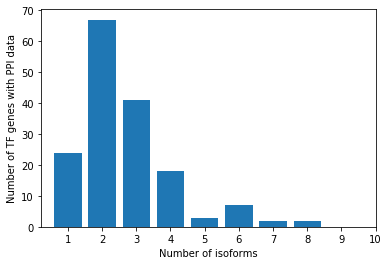

In [7]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data');

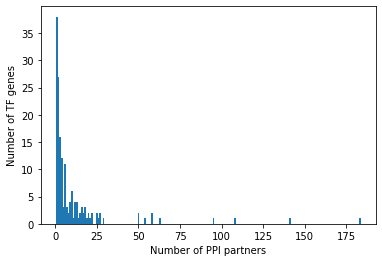

In [8]:
#    - Number of partners per TF gene

n_ppi = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes');

In [9]:
#    - How many isoforms have 0 interactions?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'ad_clone_acc'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'ad_clone_acc'].nunique()
print('Of {} isoforms, {} have at least one positive interation'.format(a, b))

Of 440 isoforms, 242 have at least one positive interation


In [10]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 914 tested partners, 728 had at least one positive result


In [11]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))

In [12]:
# remove these interactions where none of the isoforms are 
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
       y2h['db_gene_symbol'].isin(c), :].head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score
57,tf_isoform_ppis,101216,GATA1|1/2|08A02,GATA1,1579,TEKT4,0
103,tf_isoform_ppis,100301,SMAD3|1/4|06A07,SMAD3,1579,TEKT4,0
115,tf_isoform_ppis,100697,SMAD3|4/4|06F07,SMAD3,1579,TEKT4,0
126,tf_isoform_ppis,100657,SMAD3|2/4|06G07,SMAD3,1579,TEKT4,0
138,tf_isoform_ppis,100479,SMAD3|3/4|06B08,SMAD3,1579,TEKT4,0


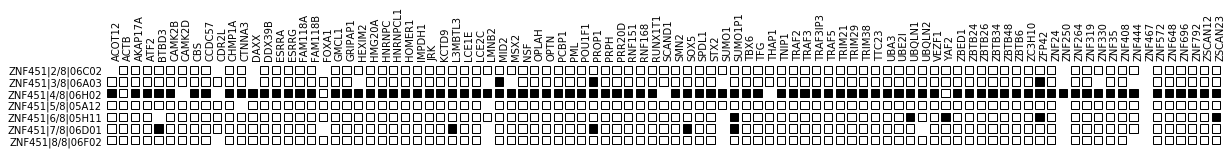

In [17]:
# Visualization for a single TF:
#     - Isoform sequences
#     - Interaction matrix

  
def y2h_per_tf_gene_plot(gene_name, data, ax=None):
    
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    min_n_isoforms = 2
    min_n_partners = 1
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        return
    if ax is None:
        ax = plt.gca()
    cplt.binary_profile_matrix(tf, ax=ax, column_label_rotation=90)
    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
gene_name = 'ZNF451'
y2h_per_tf_gene_plot(gene_name, data=y2h)

Interesting examples:

- ZNF451

In [28]:
#def load_pdi
#def load_m1h

df = pd.read_csv('a2_juan_pdi_w_unique_isoacc.tsv', sep='\t')

In [29]:
print(df.shape)
df.head()

(993, 3)


,tf,unique_acc,bait
0,DLX6,DLX6|2/2|05G01,HS218
1,DLX6,DLX6|2/2|05G01,HS394
2,DLX6,DLX6|2/2|05G01,HS661
3,DLX6,DLX6|2/2|05G01,HS51
4,DLX6,DLX6|2/2|05G01,HS129


In [20]:
df.nunique()

tf             91
unique_acc    139
bait          156
dtype: int64

In [30]:
# zero degree PDI isoforms with another isoform of the gene which had at least one bait interaction
df = pd.read_csv('a2_juan_isoforms_wo_pdi.tsv', sep='\t')
print(df.shape)
df.head()

(50, 2)


,tf,unique_acc
0,E2F3,E2F3|4/4|10G08
1,FOXP2,FOXP2|10/10|06A10
2,FOXP2,FOXP2|6/10|06F12
3,GATA3,GATA3|2/2|04H01
4,IRF9,IRF9|5/6|04H03


In [23]:
def load_m1h_results():
    """
    
    
    """
    df = pd.read_csv('a_m1h_final_table.tsv', sep='\t')
    df = df.rename(columns={'pos_acc': 'clone_acc'})
    for column in df.columns:
        if column.startswith('M1H_rep'):
            df[column] = np.log10(df[column])
    return df


m1h = load_m1h_results()

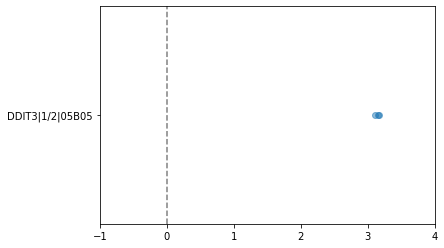

In [32]:
def plot_data_per_tf(data, tf_gene_name, ax=None):
    if ax is None:
        ax = plt.gca()
    rep_columns = [c for c in data.columns if c.startswith('M1H_rep')]
    ax.scatter(
        y=[acc for acc in data.loc[data['gene'] == tf_gene_name, 'clone_acc'].values
           for __ in range(len(rep_columns))],
        x=data.loc[data['gene'] == tf_gene_name, rep_columns].values.flatten(),
        alpha=0.5
        )
    ax.set_xlim(-1, 4)
    ax.axvline(0, linestyle='--', color='grey')
    
    
plot_data_per_tf(m1h, 'DDIT3')

In [25]:
gene_name = 'ZNF451'
single_gene_results(gene_name, data=y2h)
plot_data_per_tf(m1h, gene_name)

NameError: name 'single_gene_results' is not defined